# Visualizing Convolution Filters 


First we import the needed libraries.

In [1]:
import cv2
import Tkinter as tk
import tkFileDialog
import os
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from Preprocessing import load_images
from keras.utils import np_utils
import tensorflow.contrib.slim as slim
import math
%matplotlib inline

Using TensorFlow backend.


In [2]:
tk.Tk().withdraw()
path_Train=tkFileDialog.askdirectory()
print path_Train

/home/akash/Skin-Lesion-Analysis-Towards-Melanoma-Detection/Dataset/Training_images Segmented


In [3]:
X_Train=load_images(path_Train)
X_Train=np.array(X_Train)
X_Train.shape
X_Train=np.reshape(X_Train,[-1,np.prod(X_Train.shape[1:])])
X_Train.shape

(2000, 12288)

In [4]:
tk.Tk().withdraw()
path_Test=tkFileDialog.askdirectory()
print path_Test
X_Test=load_images(path_Test)
X_Test=np.array(X_Test)
X_Test.shape
X_Test=np.reshape(X_Test,[-1,np.prod(X_Test.shape[1:])])
X_Test.shape

/home/akash/Skin-Lesion-Analysis-Towards-Melanoma-Detection/Dataset/Testing_images Segmented


(600, 12288)

In [5]:
data_Train=pd.read_csv("/home/akash/Skin-Lesion-Analysis-Towards-Melanoma-Detection/ISIC-2017_Training_Part3_GroundTruth.csv")
data_Test=pd.read_csv("/home/akash/Skin-Lesion-Analysis-Towards-Melanoma-Detection/ISIC-2017_Test_v2_Part3_GroundTruth.csv")
data_Train=data_Train.iloc[0:2000,1]
data_Test=data_Test.iloc[0:600,1]
print data_Train.shape
print data_Test.shape

(2000,)
(600,)


In [6]:
y_Train=data_Train
y_Test=data_Test
y_Train=np.array(y_Train)
y_Test=np.array(y_Test)

In [7]:
y_Train = np_utils.to_categorical(data_Train)
y_Test = np_utils.to_categorical(data_Test)
print y_Train.shape
print y_Test.shape

(2000, 2)
(600, 2)


In [8]:
def center_normalize(x):
    return (x-np.mean(x))/np.std(x)
X_Train=center_normalize(X_Train)
X_Test=center_normalize(X_Test)

Next we define our convolutional network. It will be a network with three sets of convolution -> pooling layers, followed by a fully connected softmax layer. I have choosen 3,3,64 to begin with. Feel free to adjust the number of convolutional filters at each layer. It is these filters we will be visualizing, so we can see in realtime what features are learned from the dataset with more or less filters.

In [9]:
tf.reset_default_graph()
x = tf.placeholder(tf.float32, [None, 4096*3],name="x-in")
true_y = tf.placeholder(tf.float32, [None, 2],name="y-in")
keep_prob = tf.placeholder("float")

x_image = tf.reshape(x,[-1,64,64,3])
hidden_1 = slim.conv2d(x_image,16,[3,3])
pool_1 = slim.max_pool2d(hidden_1,[2,2])
hidden_2 = slim.conv2d(pool_1,16,[3,3])
pool_2 = slim.max_pool2d(hidden_2,[2,2])
hidden_3_1 = slim.conv2d(pool_2,64,[3,3])
hidden_3 = slim.dropout(hidden_3_1,keep_prob)
out_y = slim.fully_connected(slim.flatten(hidden_3),2,activation_fn=tf.nn.softmax)

cross_entropy = -tf.reduce_sum(true_y*tf.log(out_y))
correct_prediction = tf.equal(tf.argmax(out_y,1), tf.argmax(true_y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

We then train the network using batch gradient descent with Adam optimization. Feel free to adjust the batch size and number of iterations to see how it effects the model accuracy.

In [10]:
batchSize = 100
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
for i in range(1001):
    train_idx=np.random.randint(X_Train.shape[0],size=100)
    batch_x_Train=X_Train[train_idx,:]
    batch_y_Train=y_Train[train_idx]
    sess.run(train_step, feed_dict={x:batch_x_Train,true_y:batch_y_Train, keep_prob:0.5})
    if i % 100 == 0 and i != 0:
        trainAccuracy = sess.run(accuracy, feed_dict={x:batch_x_Train,true_y:batch_y_Train, keep_prob:1.0})
        print("step %d, training accuracy %g"%(i, trainAccuracy))

step 100, training accuracy 0.82
step 200, training accuracy 0.8
step 300, training accuracy 0.84
step 400, training accuracy 0.8
step 500, training accuracy 0.86
step 600, training accuracy 0.79
step 700, training accuracy 0.85
step 800, training accuracy 0.82
step 900, training accuracy 0.86
step 1000, training accuracy 0.9


In [11]:
train_idx=np.random.randint(X_Test.shape[0],size=100)
batch_x_Test=X_Test[train_idx,:]
batch_y_Test=y_Test[train_idx]
testAccuracy = sess.run(accuracy, feed_dict={x:batch_x_Test,true_y:batch_y_Test, keep_prob:1.0})
print("test accuracy %g"%(testAccuracy))

test accuracy 0.82


Now we define a couple functions that will allow us to visualize the network. The first gets the activations at a given layer for a given input image. The second plots those activations in a grid.

In [12]:
def getActivations(layer,stimuli):
    units = sess.run(layer,feed_dict={x:np.reshape(stimuli,[1,4096*3],order='F'),keep_prob:1.0})
    plotNNFilter(units)

In [13]:
def plotNNFilter(units):
    filters = units.shape[3]
    plt.figure(1, figsize=(64,64))
    n_columns = 6
    n_rows = math.ceil(filters / n_columns) + 1
    plt.axis('off')
    for i in range(filters):
        plt.subplot(n_rows, n_columns, i+1)
        plt.title('Filter ' + str(i))
        plt.imshow(units[0,:,:,i], interpolation="nearest",cmap="gray")

Now we can choose an image to pass through the network to visualize the network activation, and look at the raw pixels of that image.

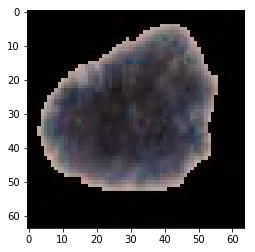

In [14]:
X_Train=load_images(path_Train)
X_Train=np.array(X_Train)
imageToUse = X_Train[0]
plt.imshow(imageToUse)

In [15]:
X_Train1=np.reshape(X_Train,[-1,np.prod(X_Train.shape[1:])])
X_Train1.shape
imageToUse=X_Train1[0]

In [20]:
?slim.conv2d()

Now we can look at how that image activates the neurons of the first convolutional layer. Notice how each filter has learned to activate optimally for different features of the image. 

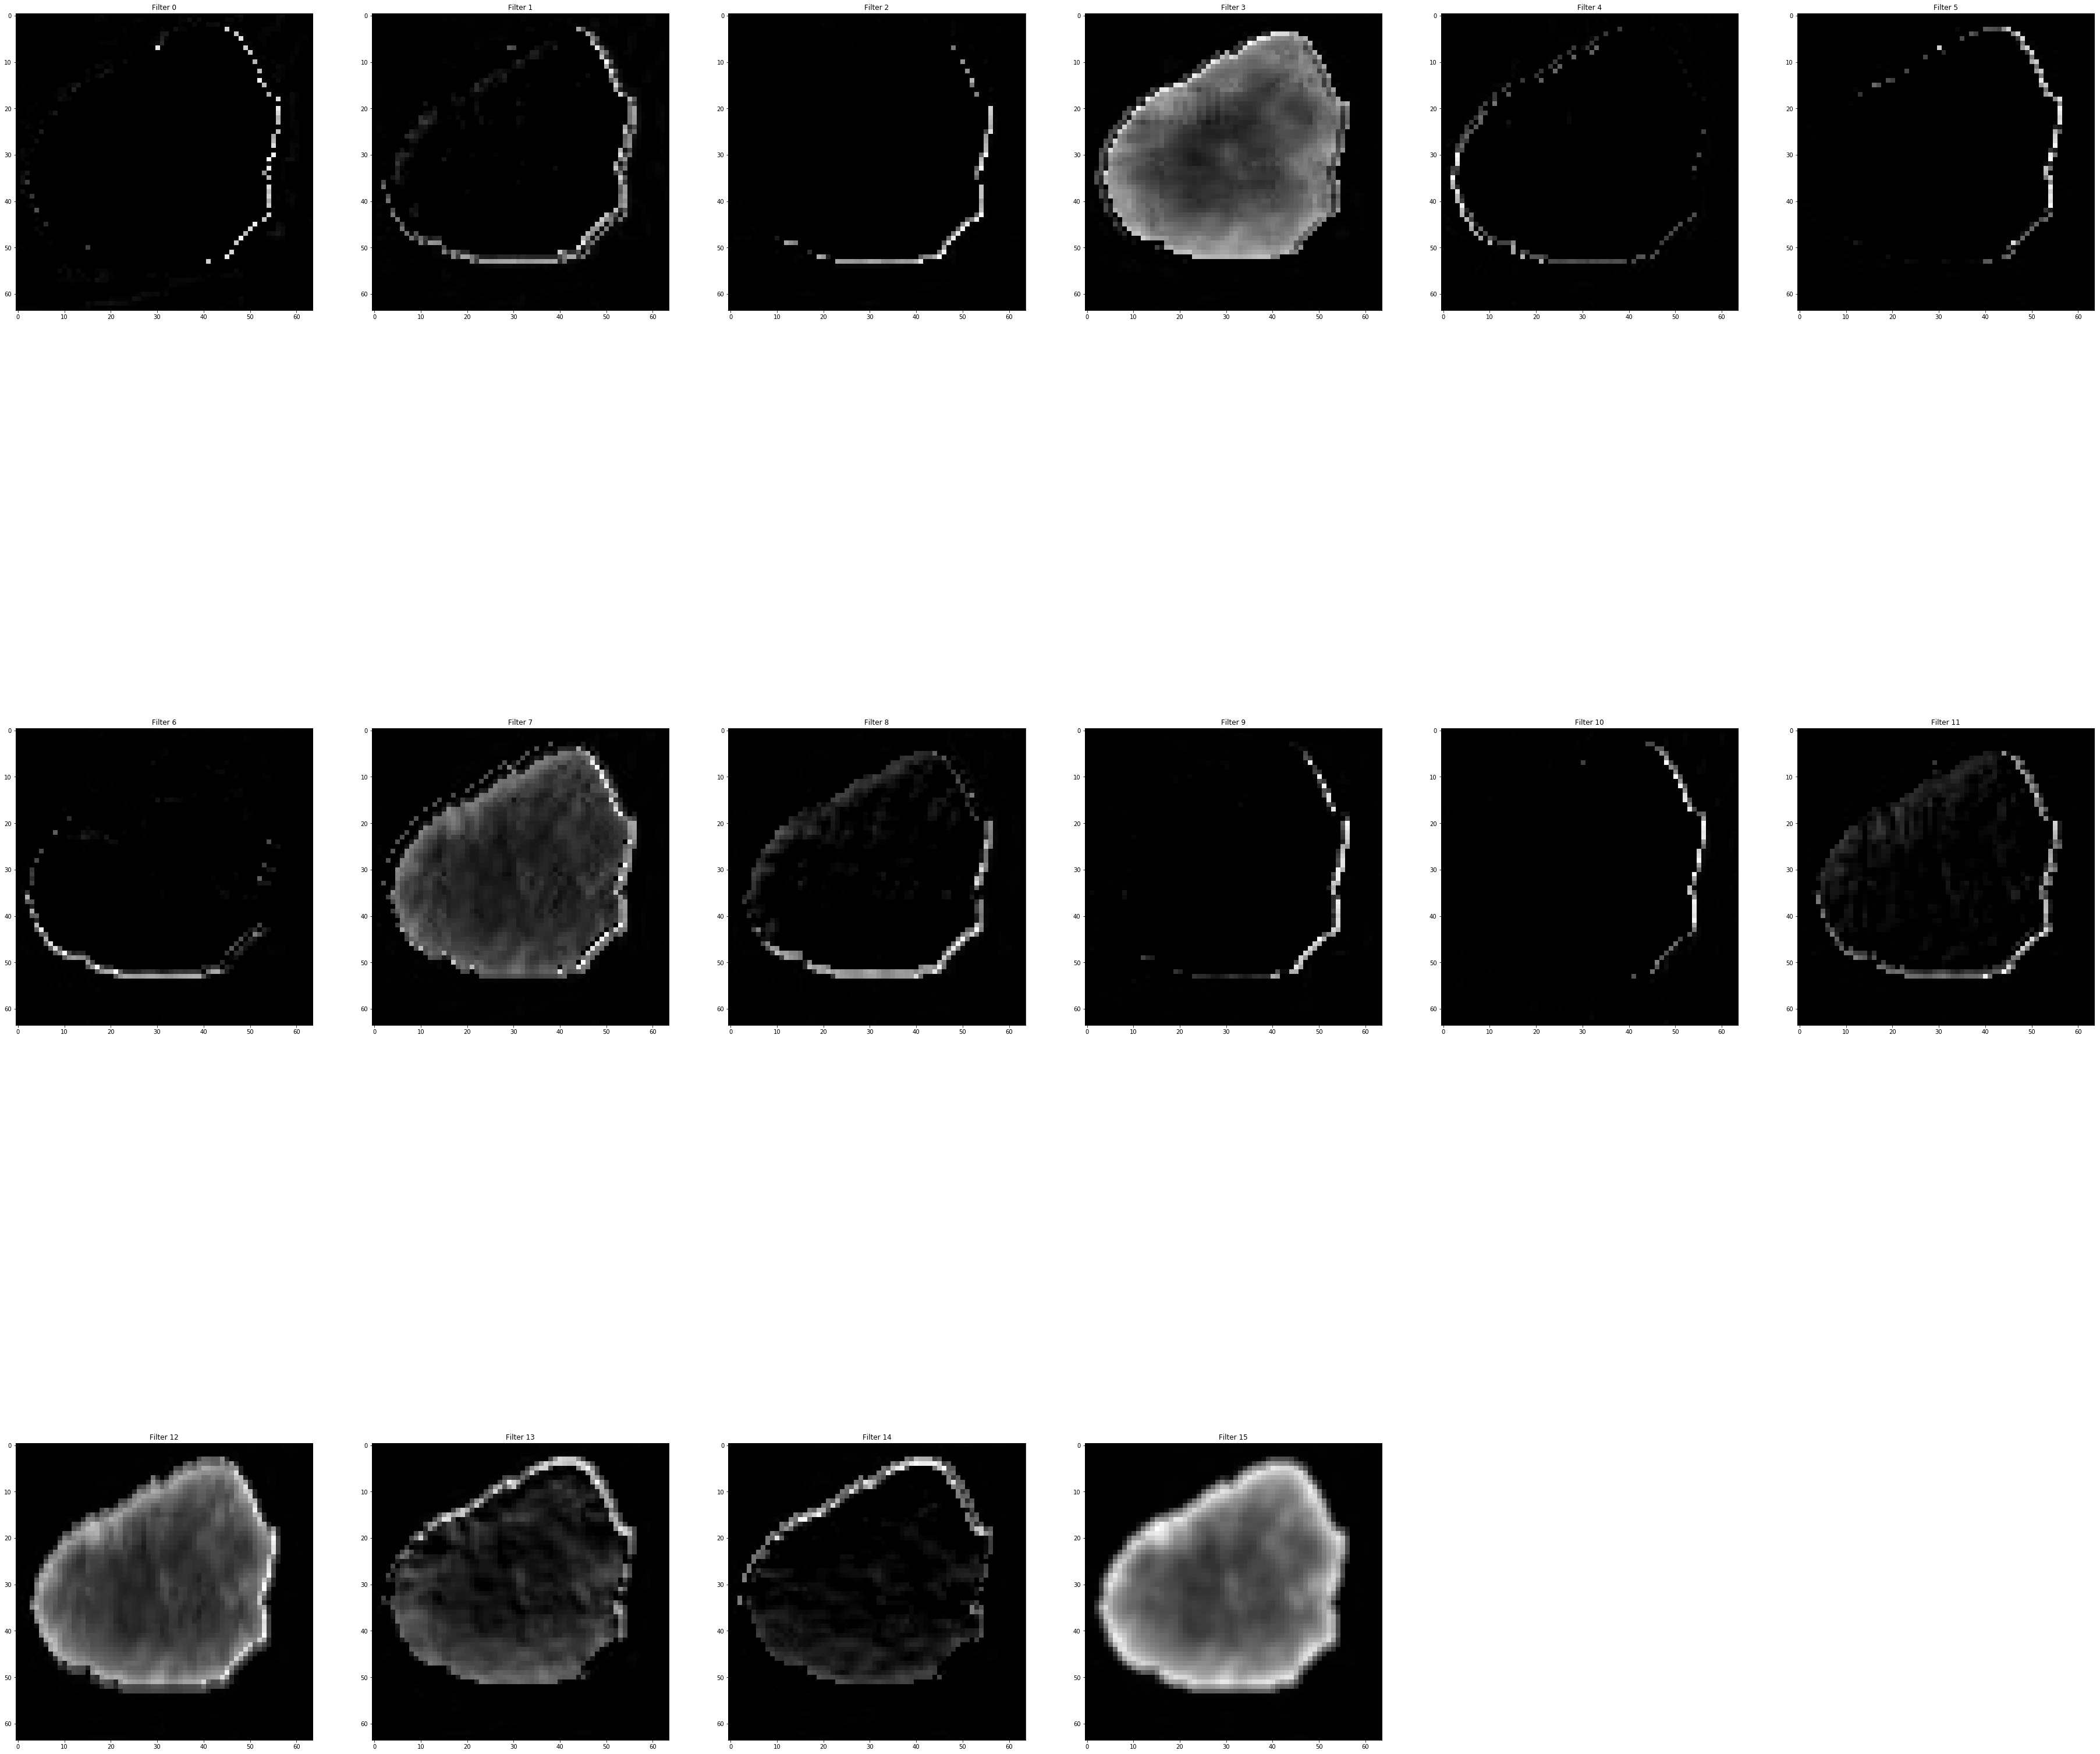

In [24]:
getActivations(hidden_1,imageToUse)

We can do this again for the second layer...

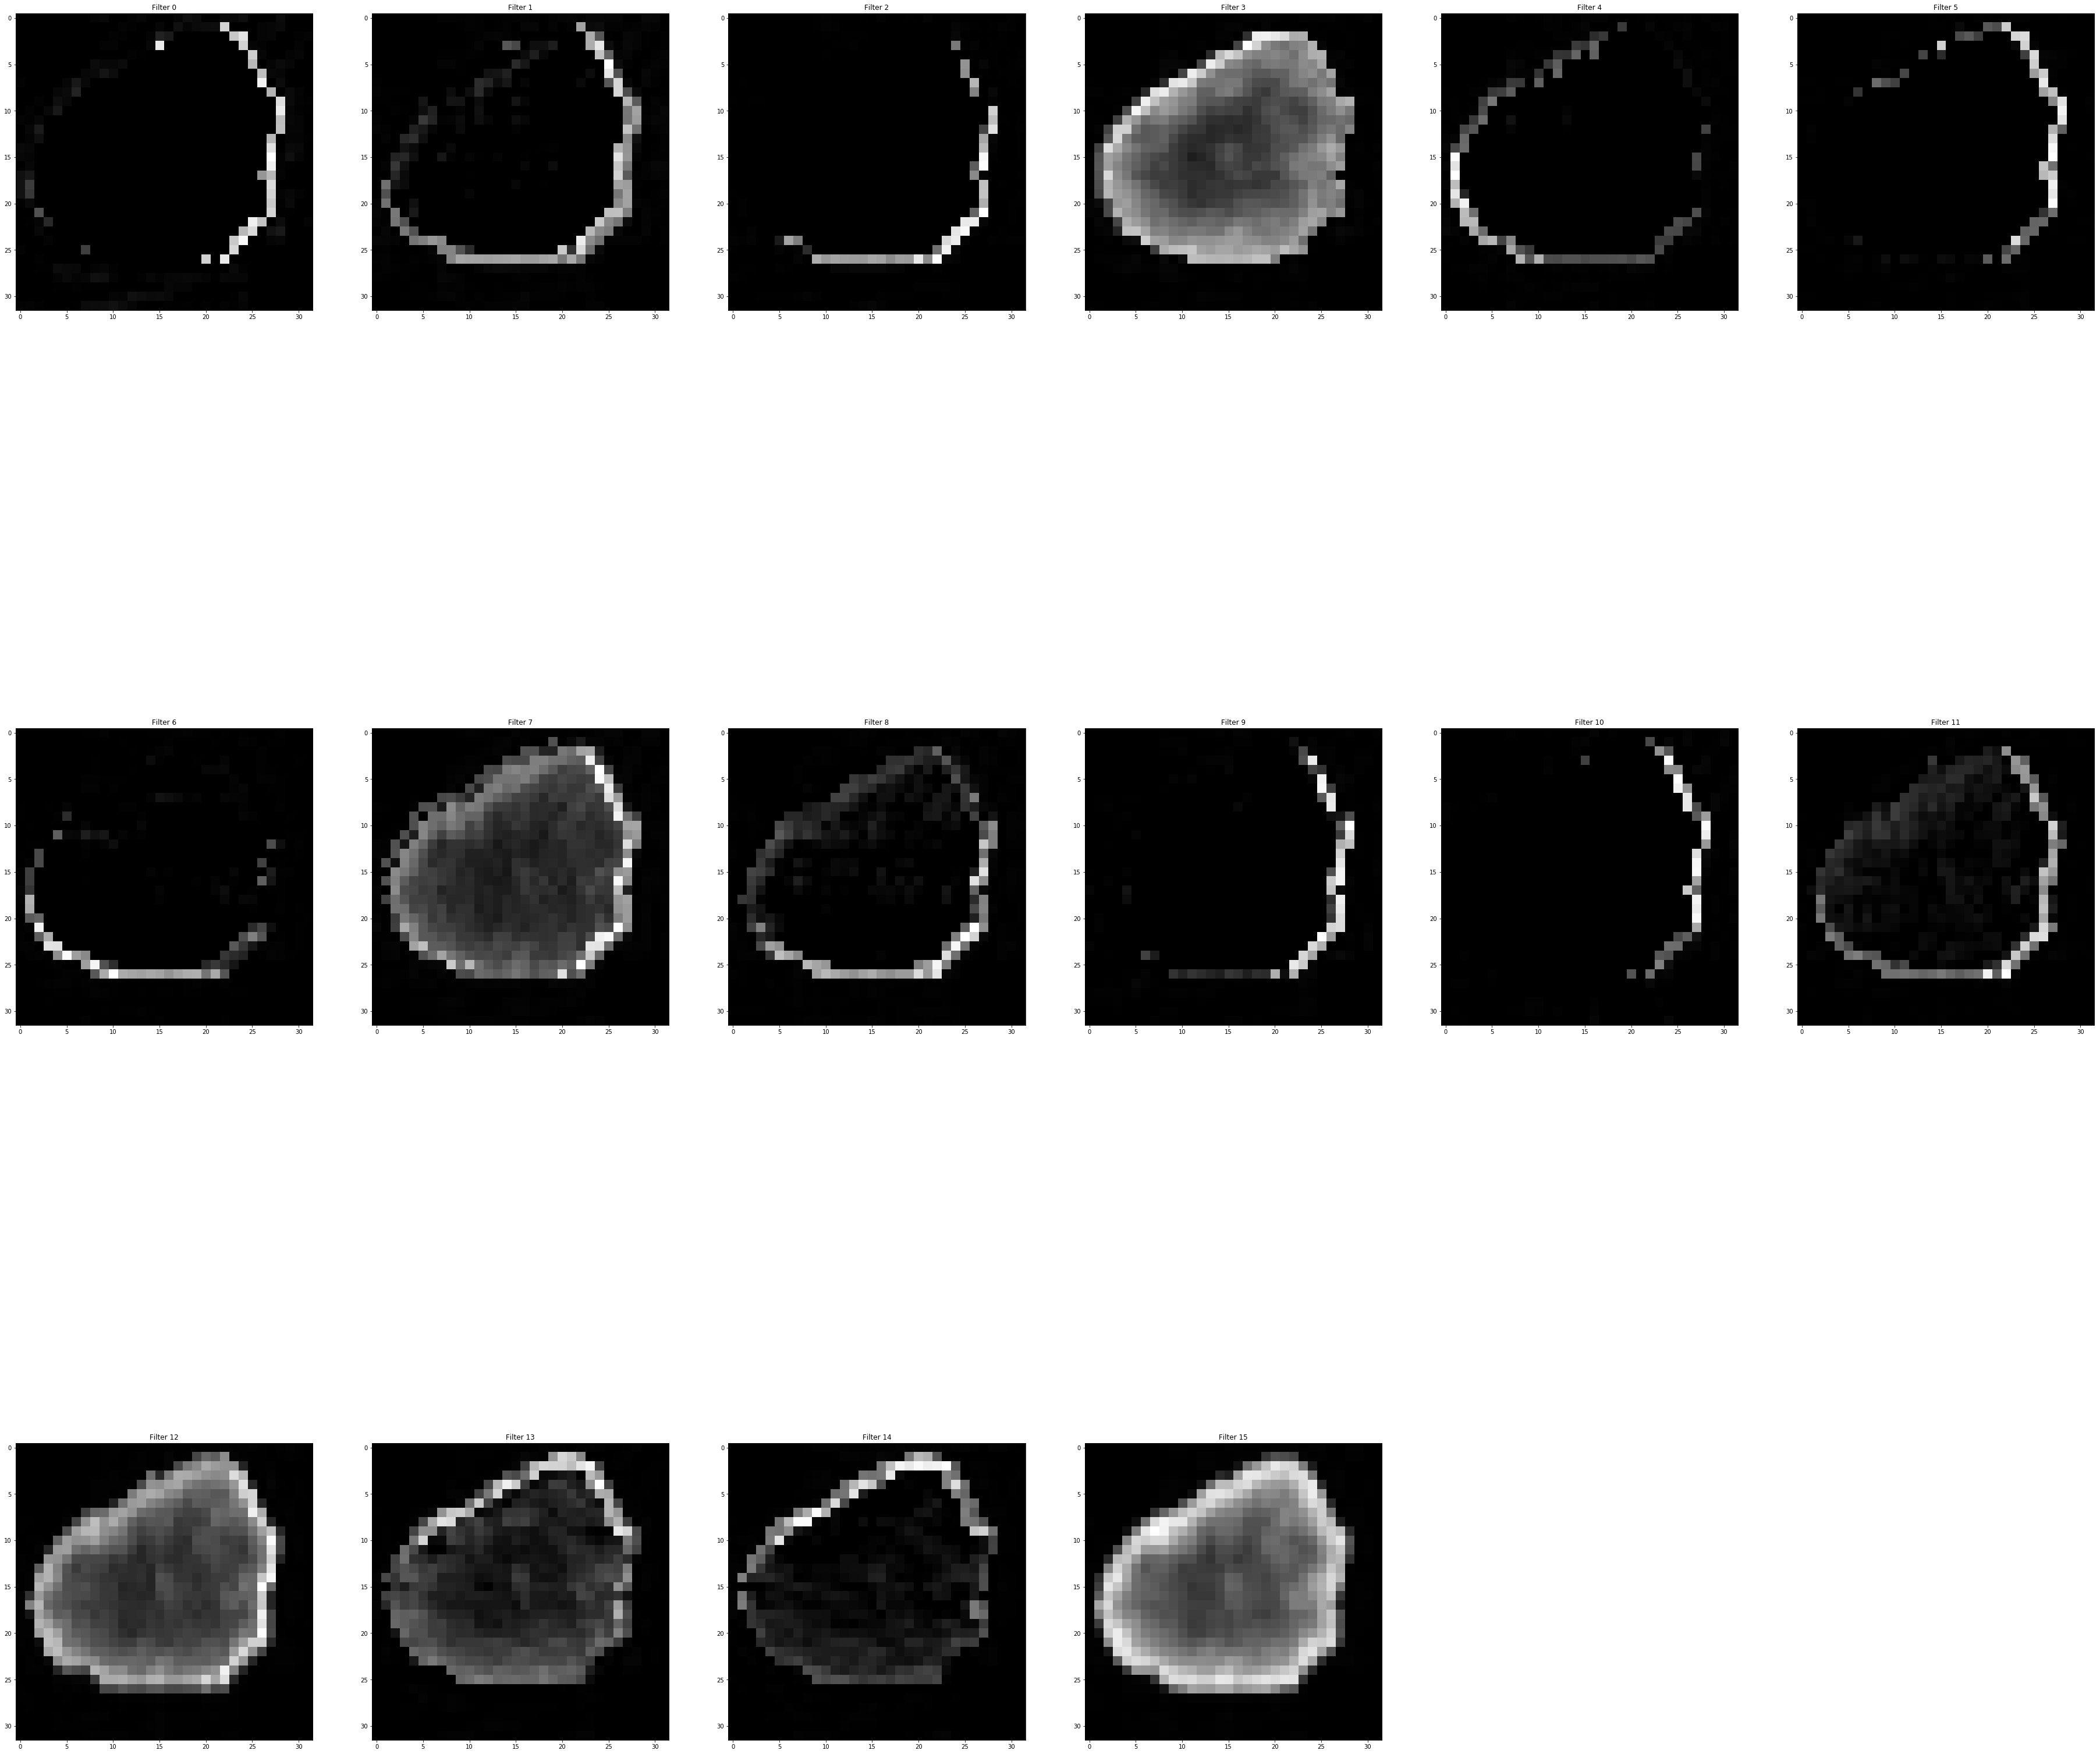

In [25]:
getActivations(pool_1,imageToUse)

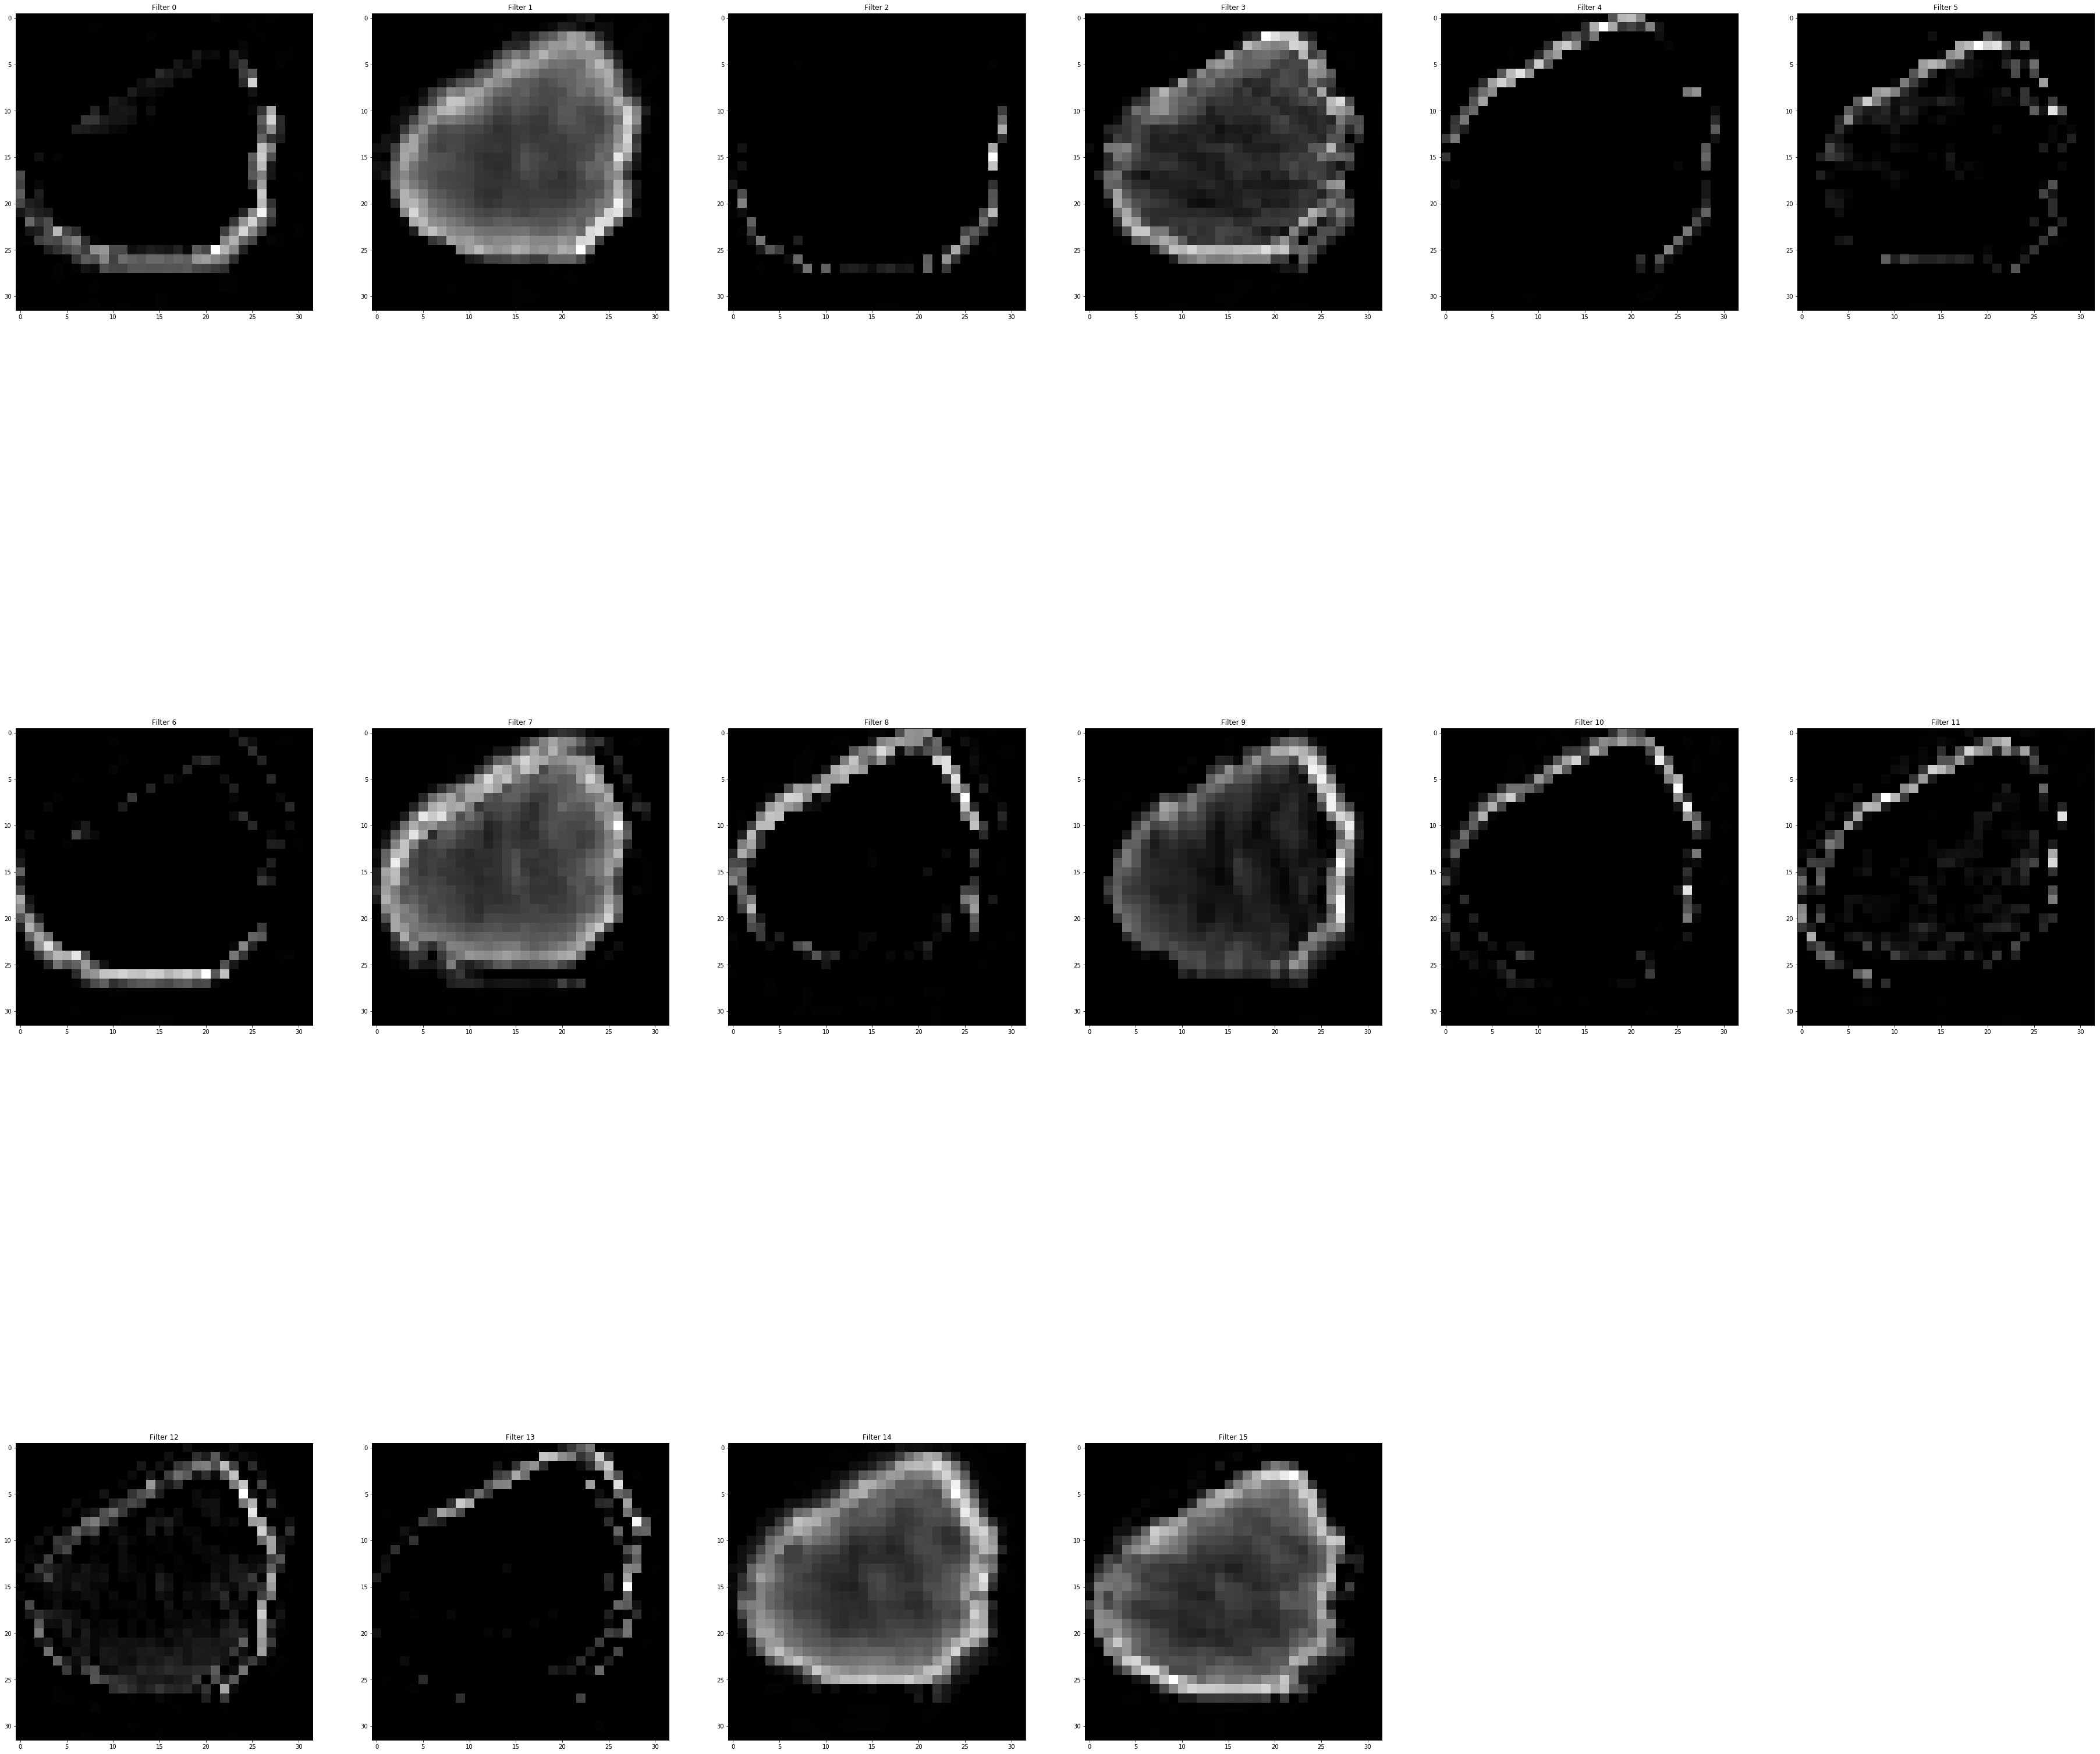

In [21]:
getActivations(hidden_2,imageToUse)

...and the third.

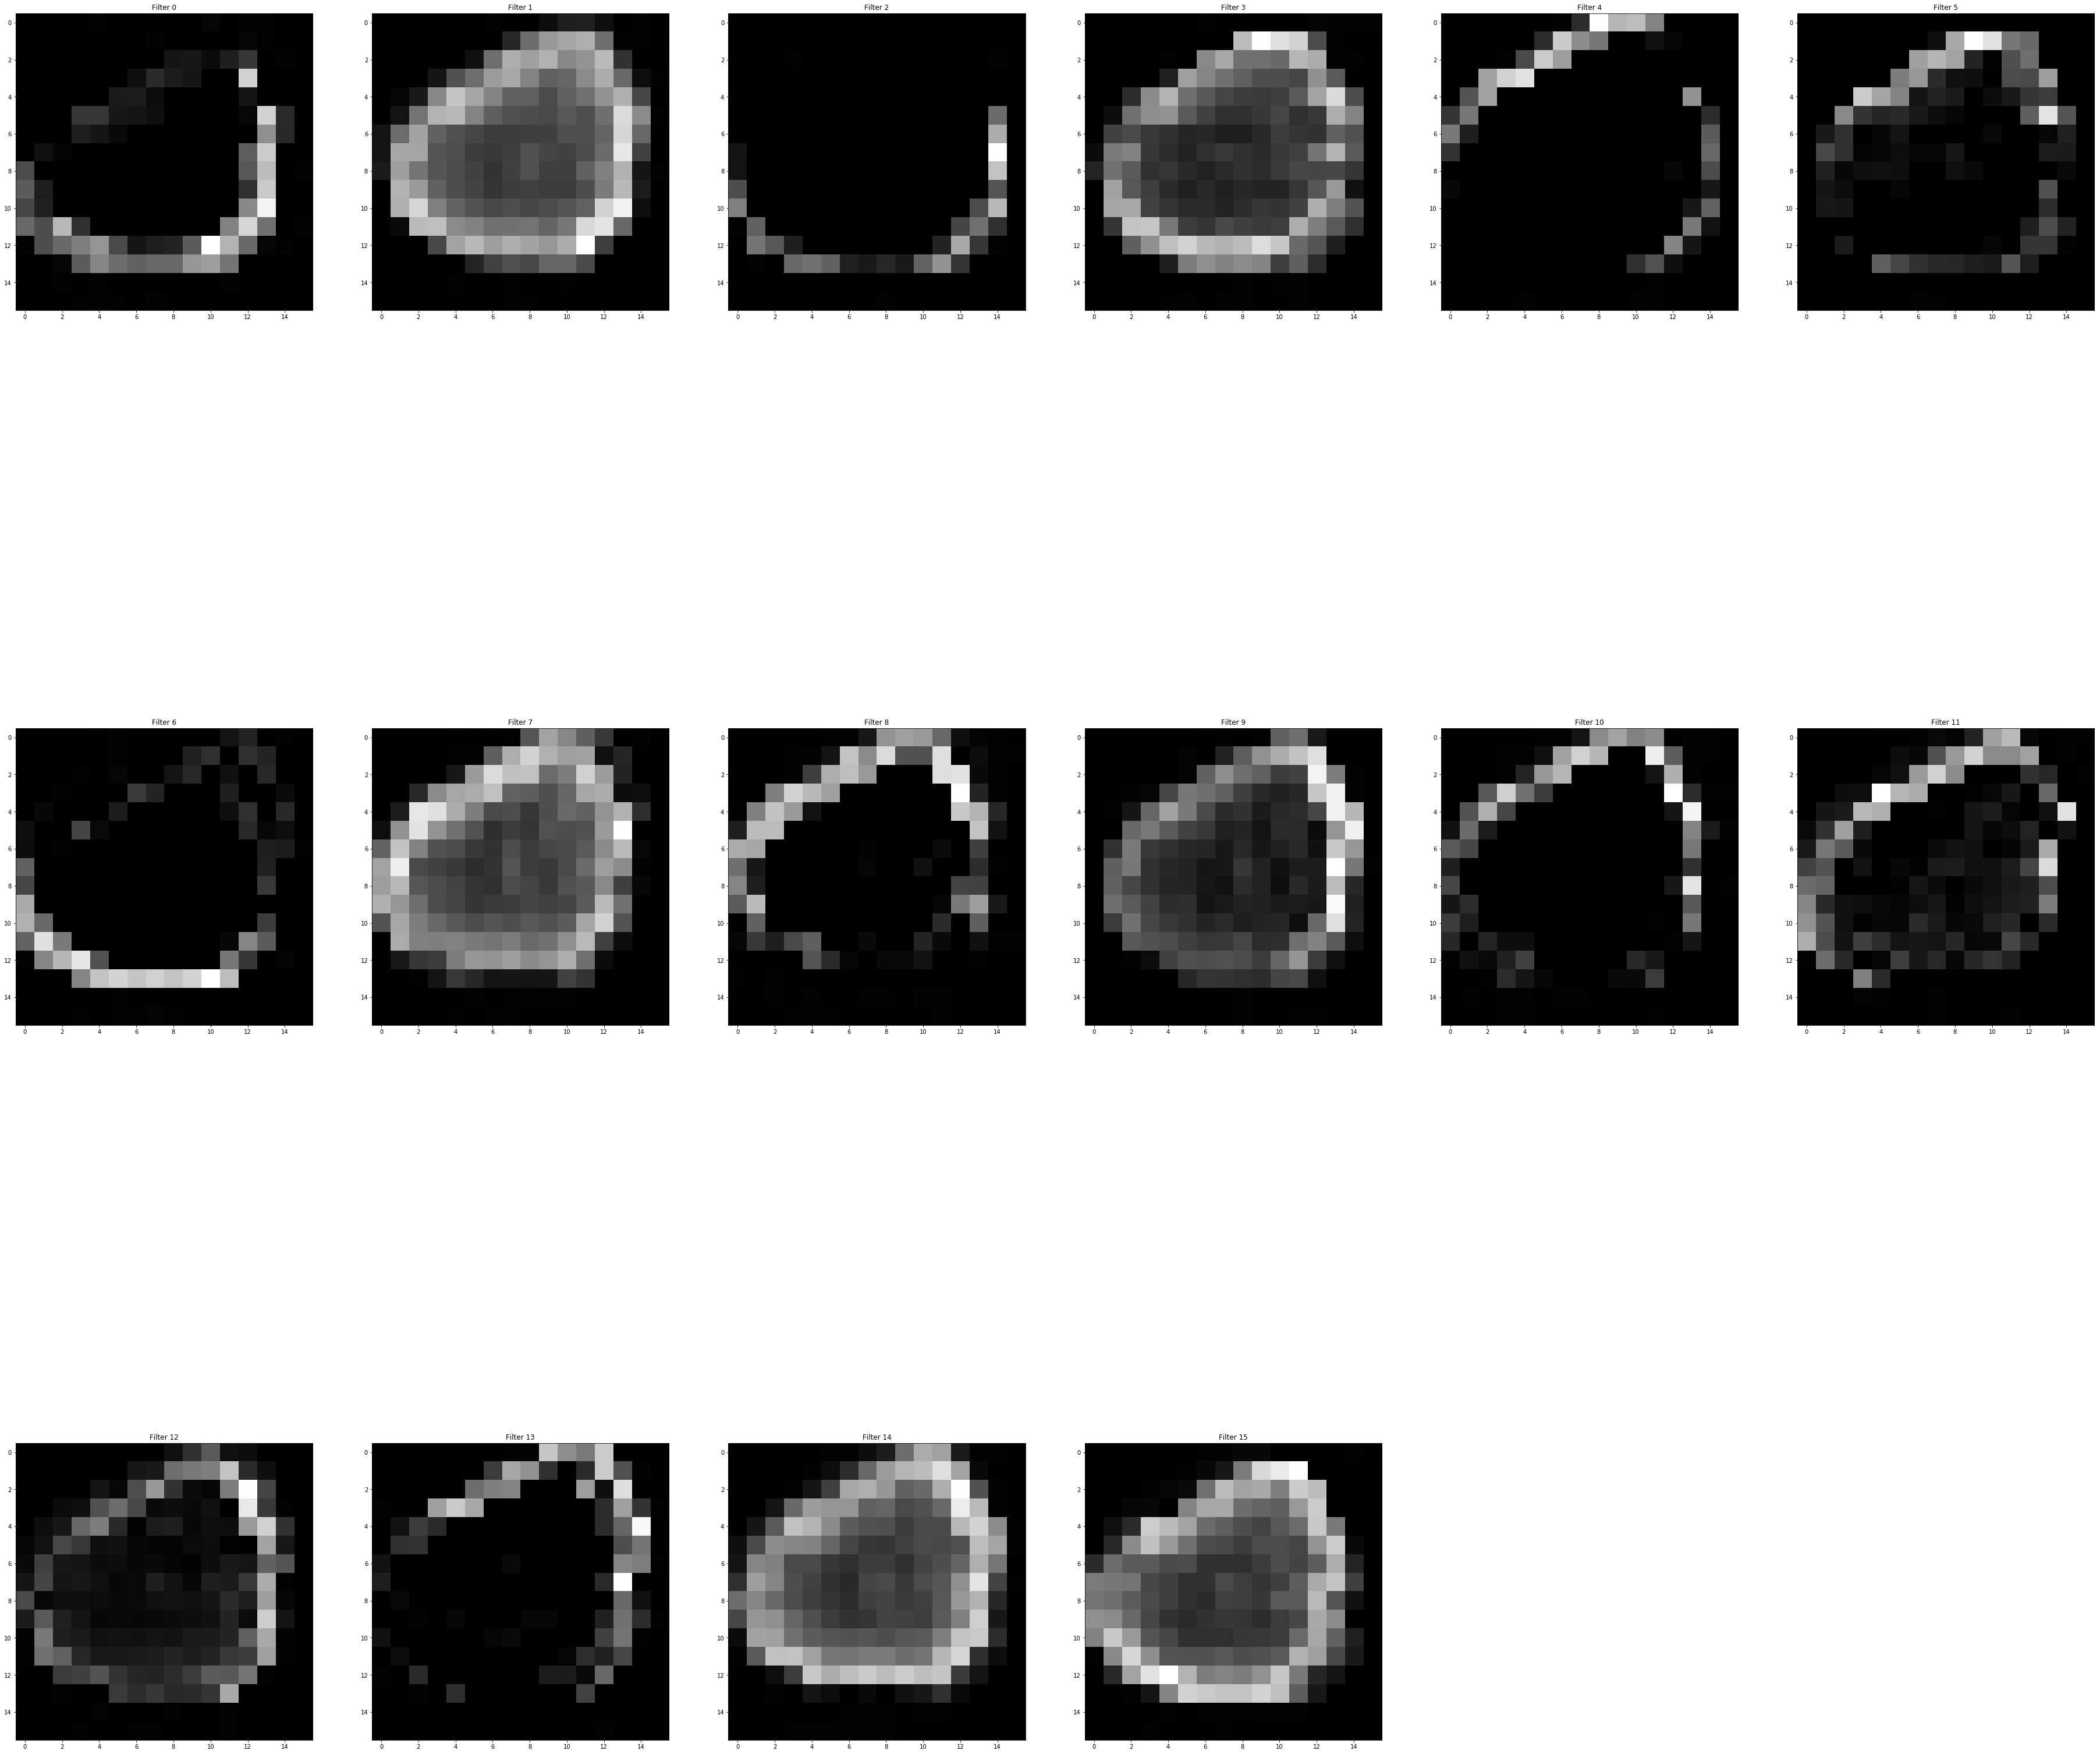

In [22]:
getActivations(pool_2,imageToUse)

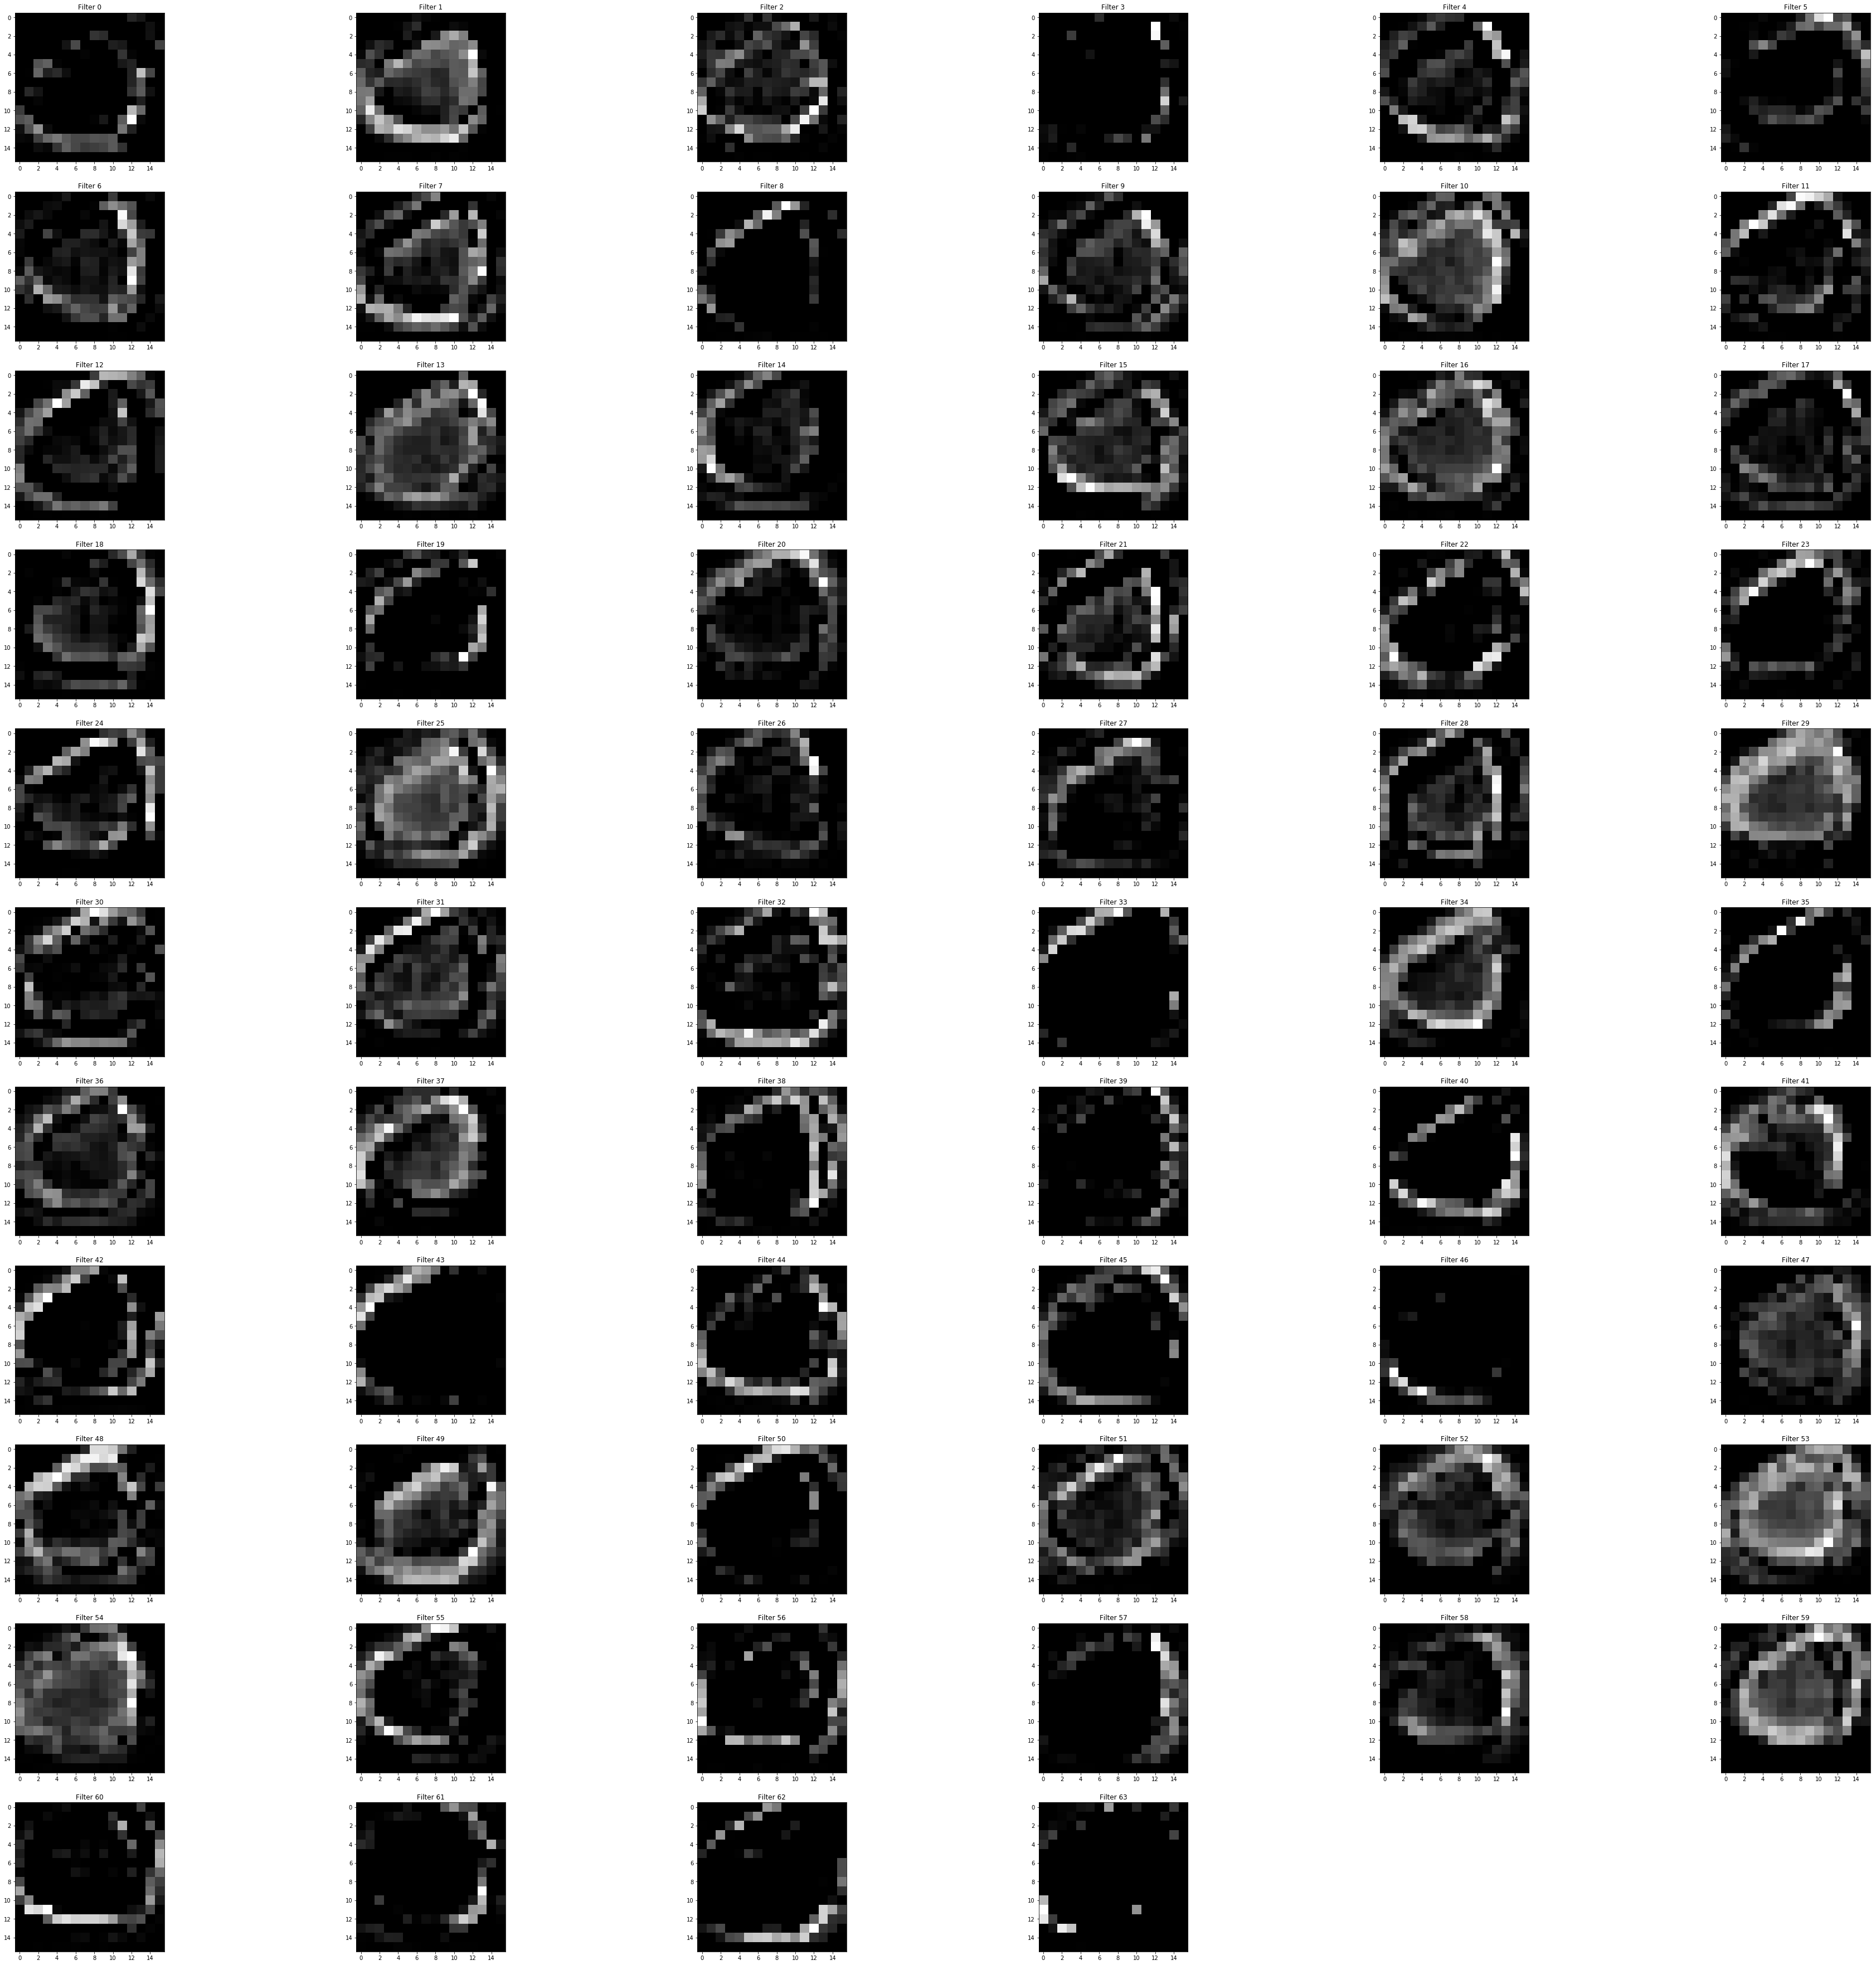

In [23]:
getActivations(hidden_3_1,imageToUse)